--- LEYENDO DATOS DE fractal_data.csv ---


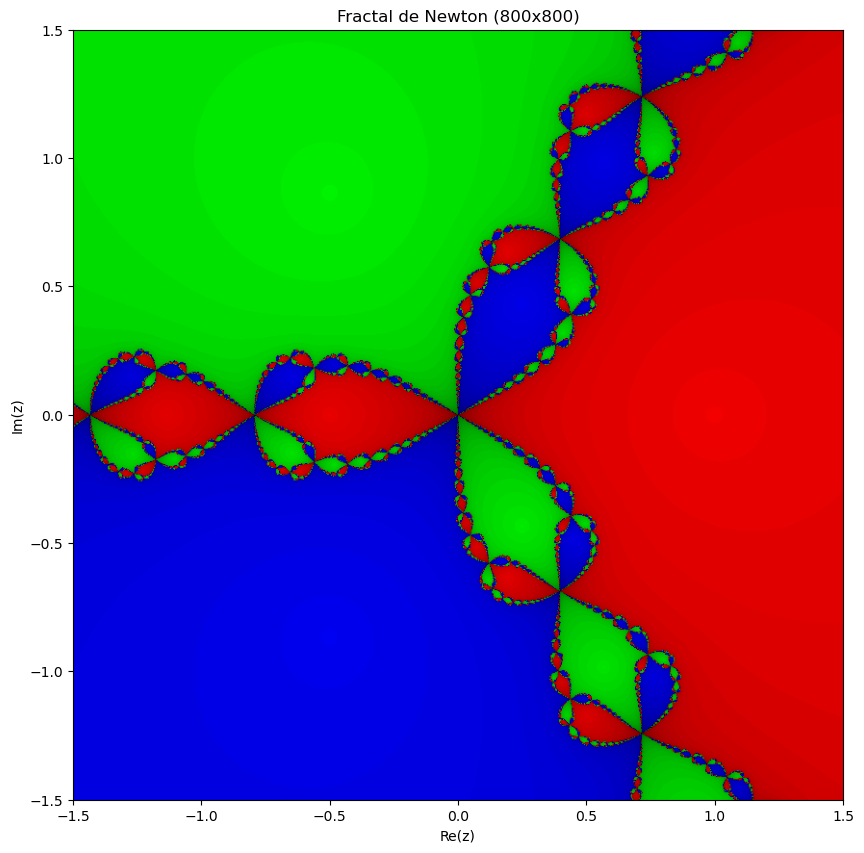

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# Configuración del archivo
FILENAME = "fractal_data.csv"

def main():
    print(f"--- LEYENDO DATOS DE {FILENAME} ---")
    
    try:
        df = pd.read_csv(FILENAME)
    except FileNotFoundError:
        print("❌ Error: No se encontró 'fractal_data.csv'.")
        print("   Asegúrate de ejecutar primero tu programa en C.")
        return

    num_pixels = len(df)
    resolution = int(math.sqrt(num_pixels))

    # 3. Convertir los datos en matrices 2D
    roots = df['root_idx'].values.reshape((resolution, resolution))
    iters = df['iterations'].values.reshape((resolution, resolution))

    # 4. Crear imagen RGB vacía
    img = np.zeros((resolution, resolution, 3), dtype=float)

    colors = np.array([
        [1.0, 0.0, 0.0],  # Raíz 0: Rojo Puro
        [0.0, 1.0, 0.0],  # Raíz 1: Verde Puro
        [0.0, 0.0, 1.0],  # Raíz 2: Azul Puro
    ])

    mask_ok = roots >= 0  # Píxeles que sí convergieron
    img[mask_ok] = colors[roots[mask_ok]]

    # 7. Aplicar sombras (Brillo)
    # Normalizamos las iteraciones de 0 a 1 usando el máximo encontrado
    max_iter = iters.max() if iters.max() > 0 else 1
    
    brightness = 1.0 - (iters / max_iter) * 0.8
    brightness = np.clip(brightness, 0, 1)  # Aseguramos que el brillo esté entre 0 y 1

    # Multiplicamos el color base por el brillo en los 3 canales
    for c in range(3):
        img[..., c] *= brightness

    # Los que no convergieron (índice -1) se quedan en Negro (0,0,0) automáticamnete

    # 8. Mostrar gráfico
    plt.figure(figsize=(10, 10))
    
    # Ajusta 'extent' a tus coordenadas Xmin, Xmax, Ymin, Ymax reales
    plt.imshow(img, origin='lower', extent=[-1.5, 1.5, -1.5, 1.5])
    
    plt.title(f"Fractal de Newton ({resolution}x{resolution})")
    plt.xlabel("Re(z)")
    plt.ylabel("Im(z)")
    
    plt.show()

if __name__ == "__main__":
    main()